In [1]:
# This notebook mocks up a simple EOS likelihood calculation with Gaussians, 
# then shows that lwp reproduces the same result

%matplotlib inline

In [2]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import os
import bilby.gw.conversion as conversion
import matplotlib.pyplot as plt
import copy
from  scipy.special import logsumexp, rel_entr
from scipy.stats import multivariate_normal
import seaborn as sns

import sys
sys.path.insert(0,'/home/philippe.landry/lwp')
import lwp
import lwp.executables.get_files as get_files

from lwp import executables

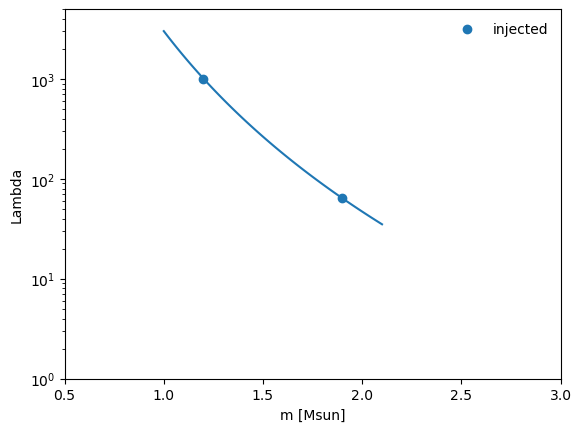

In [3]:
# pick injected parameters for BNS

m1_inj = 1.9 # keep mass ratio away from 1 to minimize impact of m1 > m2 cut
m2_inj = 1.2

L14 = 400.
Lambda = lambda m: L14*(m/1.4)**(-6) # crude approximation of m-Lambda relation for a realistic EOS
mtov = 2.1

L1_inj = Lambda(m1_inj) # set Lambdas based on assumed m-Lambda relation
L2_inj = Lambda(m2_inj)

plt.plot(np.linspace(1.,mtov,100),Lambda(np.linspace(1.,mtov,100)))
plt.scatter([m1_inj,m2_inj],[L1_inj,L2_inj],label='injected')
plt.xlabel('m [Msun]')
plt.ylabel('Lambda')
plt.yscale('log')
plt.ylim(1.,5000.)
plt.xlim(0.5,3.)
plt.legend(frameon=False)
plt.show()

In [4]:
# pick measurement uncertainties

sigma_m1 = 0.1*m1_inj # 10% relative uncertainty (68% confidence) in component masses
sigma_m2 = 0.1*m2_inj
sigma_L1 = 200. # +/- 200 absolute uncertainty (68% confidence) in Lambdas
sigma_L2 = 200.

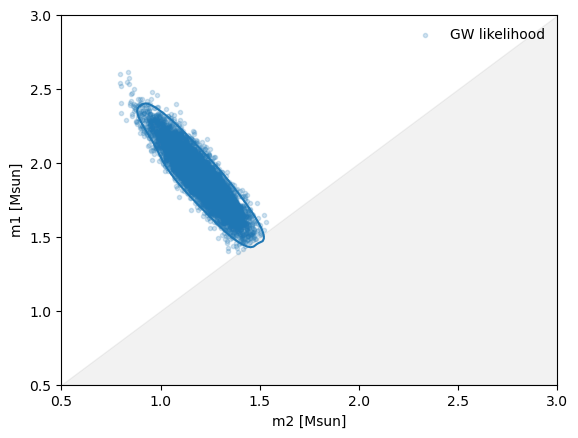

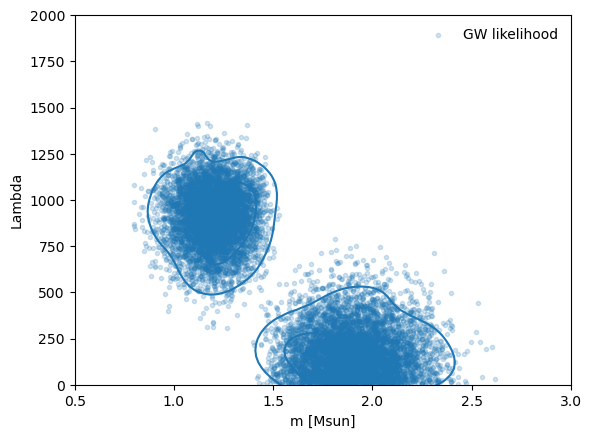

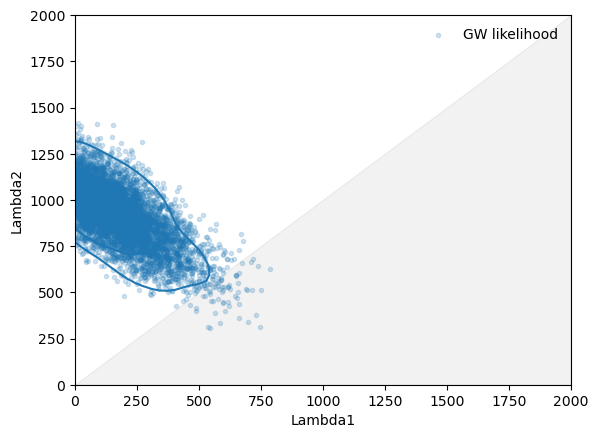

In [5]:
# build multivariate Gaussian GW likelihood

rho_m = -0.9 # pick some plausible-looking parameter correlations (could do this better, but this is just illustrative)
rho_L = -0.8
cov = np.array([[sigma_m1**2, rho_m*sigma_m1*sigma_m2, 0., 0.],[rho_m*sigma_m1*sigma_m2, sigma_m2**2, 0., 0.],[0., 0., sigma_L1**2, rho_L*sigma_L1*sigma_L2],[0., 0., rho_L*sigma_L1*sigma_L2, sigma_L2**2]])
mean = np.array([m1_inj, m2_inj, L1_inj, L2_inj]) # no detector white noise

gwlike = multivariate_normal(mean,cov) # analytic GW likelihood

nprior = 100000
np.random.seed(2023) # for reproducibility
mA_prior = np.random.uniform(0.5,3.,nprior)
mB_prior = np.random.uniform(0.5,3.,nprior)
m1_prior = np.maximum(mA_prior,mB_prior)
m2_prior = np.minimum(mA_prior,mB_prior)
L1_prior = np.random.uniform(0.,5000.,nprior)
L2_prior =np.random.uniform(0.,5000.,nprior)

def eval_gwlike(arr):
    
    evals = [float(np.where(np.any(vec) < 0. or vec[0] < vec[1], 0., gwlike.pdf(vec))) for vec in arr[0]]
    
    return evals

gwlikes = eval_gwlike(np.dstack((m1_prior,m2_prior,L1_prior,L2_prior))) # likelihood values at uniformly drawn points in parameter space, for plot

nlikes = 10000
gwsamps = np.random.multivariate_normal(mean,cov,nlikes) # also draw some likelihood samples for plots/for later use
gwsamps = np.array([gwsamp for gwsamp in gwsamps if np.all(gwsamp >= 0.)]) # throw out Lambda < 0 samples
gwsamps = np.array([gwsamp for gwsamp in gwsamps if gwsamp[0] >= gwsamp[1]]) # throw out m2 > m1 samples
m1s = gwsamps[:,0]
m2s = gwsamps[:,1]
L1s = gwsamps[:,2]
L2s = gwsamps[:,3]

plt.fill_between([0.5,3.],[0.5,3.],[0.5,0.5],color='k',alpha=0.05)
plt.scatter(m2s,m1s,marker='.',alpha=0.2,label='GW likelihood')
ax = sns.kdeplot(x=m2_prior,y=m1_prior,weights=gwlikes,levels=[0.1,0.5])
plt.xlabel('m2 [Msun]')
plt.ylabel('m1 [Msun]')
plt.xlim(0.5,3.)
plt.ylim(0.5,3.)
ax.legend(frameon=False)
plt.show()

plt.scatter(m2s,L2s,marker='.',alpha=0.2,label='GW likelihood')
plt.scatter(m1s,L1s,marker='.',alpha=0.2,c=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
ax1 = sns.kdeplot(x=m2_prior,y=L2_prior,weights=gwlikes,levels=[0.1,0.5])
ax2 = sns.kdeplot(x=m1_prior,y=L1_prior,weights=gwlikes,levels=[0.1,0.5],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
plt.xlabel('m [Msun]')
plt.ylabel('Lambda')
plt.xlim(0.5,3.)
plt.ylim(0.,2000.)
ax1.legend(frameon=False)
plt.show()

plt.fill_between([0.,2000.],[0.,2000.],[0.,0.],color='k',alpha=0.05)
plt.scatter(L1s,L2s,marker='.',alpha=0.2,label='GW likelihood')
ax = sns.kdeplot(x=L1_prior,y=L2_prior,weights=gwlikes,levels=[0.1,0.5])
plt.xlabel('Lambda1')
plt.ylabel('Lambda2')
plt.xlim(0.,2000.)
plt.ylim(0.,2000.)
ax.legend(frameon=False)
plt.show()

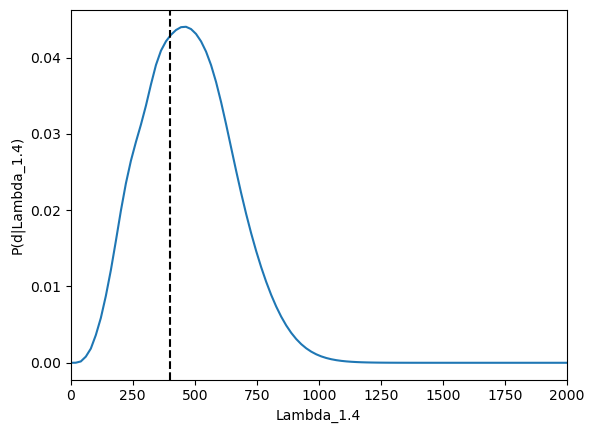

In [6]:
# assume the same kind of one-parameter EOS model as was used to generate the injection
# and calculate the Lambda_1.4 likelihood inferred from the observation
# following Eq. (5) of Landry+ PRD 2020 (arXiv:2003.04880)
# assuming also perfect knowledge of mtov and a uniform component mass prior

L14_inj = L14
L14s = np.linspace(0.,2000.,100)

eoslikes = []
for L14 in L14s:

    L1_eos = Lambda(m1_prior) # impose common EOS
    L2_eos = Lambda(m2_prior)

    eoslikes += [np.sum(eval_gwlike(np.dstack((m1_prior,m2_prior,L1_eos,L2_eos))))] # monte carlo integral of GW likelihood over masses and Lambdas
    
plt.plot(L14s,eoslikes)
plt.axvline(L14_inj,0.,1.,color='k',ls='--')
plt.xlabel('Lambda_1.4')
plt.ylabel('P(d|Lambda_1.4)')
plt.xlim(0.,2000.)
plt.show()

In [7]:
# now analyze the same GW likelihood and EOSs with lwp_pipe
# start by storing the GW likelihood samples in the required format

astro_prefix= "GaussianBNS"
np.savetxt(astro_prefix+'.csv',pd.DataFrame(data={'m1': m1s,'m2': m2s,'Lambda1': L1s,'Lambda2': L2s,'luminosity_distance_Mpc': np.full(len(m1s),40.)}), \
           delimiter=',',comments='',header='m1,m2,Lambda1,Lambda2,luminosity_distance_Mpc')
           # fix the luminosity distance, such that the prior is trivial and posterior = likelihood up to norm

astro_data_and_metadata = executables.get_files.get_astro_samples(
    astro_prefix+'.csv',
    astro_prefix+'likelihood.csv',
    download_url=None,
    max_num_pe_samples=None,
    load_samples_kwargs={},
    scan_likelihood=True,
    scan_likelihood_kwargs={'cols': ['m1', 'm2', 'Lambda1', 'Lambda2'], 'tol':1e-2, 'bwrng': (0.01,0.51), 'prior_name': 'flat_m1m2det', 'prior_columns': ['m1','m2','luminosity_distance_Mpc']},
    verbose=True
)

astro_data = astro_data_and_metadata["data"]
bandwidth = astro_data_and_metadata["bandwidth"]
print('optimal bw: '+str(bandwidth))
chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

successfully got 6101 pe samples,
Processing GaussianBNSlikelihood.csv...
Searching for optimal bandwidth...
Saving metadata...
optimal bw: 0.2321253818010797


In [8]:
# next, store the EOSs in the required format,
# i.e. a dict mapping an integer EOS number to a tabulated m-Lambda relation

import h5py

m_grid = np.linspace(1.,mtov,1000)

macro_data = {}
for eos_num,L14 in enumerate(L14s):
    
    Ls = Lambda(m_grid)
    ns_data = pd.DataFrame(data={'M': m_grid,'Lambda': Ls})
    macro_data[eos_num] = ns_data
    
eosfile = h5py.File('simple_mLambda_tables.h5', 'w')

id_set = eosfile.create_dataset('id',data=np.arange(eos_num))
ns_set = eosfile.create_group('ns')
for key, value in macro_data.items():
    ns_set.create_dataset(str(key),data=np.array(macro_data[key]))

eosfile.close()

In [9]:
# dump the config ("ini") file needed to run lwp-pipe bin script;
# just call `bin/lwp-pipe example_nb.ini` and the call will execute

result = executables.lwp_pipe(eos_indices = np.arange(eos_num),
                    retrieve_macro_data = lambda index: macro_data[index], 
                    gw_posterior_samples = astro_data,
                    likelihood_bandwidth=bandwidth, 
                    likelihood_prior_key='flat_m1m2',
                    save_likelihoods=f"./{astro_prefix}_post.csv",
                    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv",
                    mc_marginalization_range=chirp_mass_range,
                    num_marginalization_points=5000,
                    seed=12345,
                    dump_config=astro_prefix+".ini", 
                    dump_config_kwargs={"config_kwargs": {"eos-indices": "simple_mLambda_indices.csv"}, 
                                        "lwp_pipe_data_kwargs":{"gw_posterior_samples": astro_prefix+".csv",
                                                                "eos_samples_h5_path":'simple_mLambda_tables.h5', 
                                                                "eos_samples_h5_macro_subgroup":"ns",
                                                                "outdir":"DefaultOutdir"}})

In [10]:
# compute the EOS likelihoods with the main lwp executable

result = executables.lwp_pipe(
    eos_indices = np.arange(eos_num),
    retrieve_macro_data = lambda index: macro_data[index], 
    gw_posterior_samples = astro_data,
    likelihood_bandwidth=bandwidth,
    likelihood_prior_key='flat_m1m2',
    mc_marginalization_range=chirp_mass_range,
    num_marginalization_points=5000,
    save_likelihoods=f"./{astro_prefix}_post.csv",
    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv")

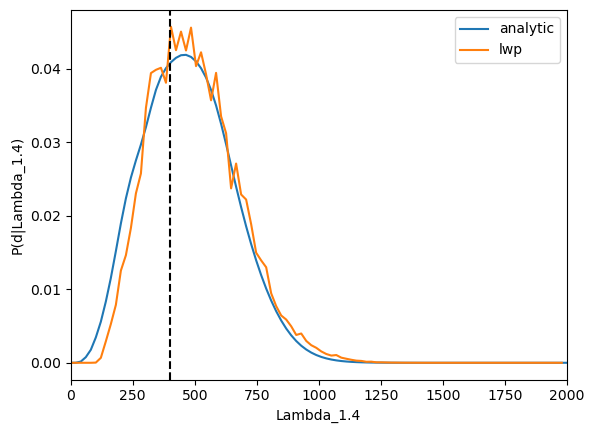

In [11]:
# load the m-Lambda tables and the computed EOS likelihoods
# plot the Lambda_1.4 likelihood and compare against the analytic calculation

import scipy

eos_data = h5py.File('simple_mLambda_tables.h5', 'r')
eos_ids = eos_data['id']
ns_datas = eos_data['ns']

L14s_lwp = []
for eos_id in eos_ids:
    ns_data = ns_datas[str(eos_id)]
    ms, Ls = ns_data[:,0], ns_data[:,1]
    Lambda_of_m = scipy.interpolate.interp1d(ms,Ls,kind='linear',bounds_error=False,fill_value=0.)
    L14s_lwp += [Lambda_of_m(1.4)]
    
like_data = np.genfromtxt(astro_prefix+'_eos.csv',names=True,dtype=None,delimiter=',')
eoslikes_lwp = np.exp(like_data['logmargweight'])

plt.plot(L14s,eoslikes/np.sum(eoslikes),label='analytic')
plt.plot(L14s_lwp,eoslikes_lwp/np.sum(eoslikes_lwp),label='lwp')
plt.axvline(L14_inj,0.,1.,color='k',ls='--')
plt.xlabel('Lambda_1.4')
plt.ylabel('P(d|Lambda_1.4)')
plt.xlim(0.,2000.)
plt.legend()
plt.show()